# MTG NLP - 5 - Sentiment Analysis with BERT
## BERT Overview
BERT (for Bidirectional Encoder Representations from Transformers) is a stack of layers of Transformers encoders that outputs the hidden state representation of the input sequence. BERT is designed to be trained and used in a pre-trained and then fine-tune scheme; the pre-train step is done in a unsupervised fashion in two steps: Masked Language model and Next sentence prediction. First one (MLM) randomly replaces words from training sentences with an special token ([MASK]) and Bert then tries to predict the missing tokens using cross entropy loss on the replaced token. The second method uses the sentence pair input available on BERT using the special separation tokens ([SEP]) to input 2 sentences, A and B. B is set 50% of times as the one inmediately following A in the original corpus and the rest of times it is randomly picked from the corpus. BERT then tries to predict the labels IsNext and NotNext in a binary cross entropy loss. 

Fine-tune is then up to the consumer. In this notebook, Sentiment Classification will be used, wich is a form of sequence tagging. For that, the output representantion of the [CLS] token is fed to an output layer, usually a Dense layer with cross entropy loss and outputs size equal to the number of categories. During fine=tuning, the idea is to load the pre-trained model and then update _all_ parameters with the new task-specific output layer.

BERT is usually found pre-trained using the common literature datasets. The English BERT, for example, was pretrained with BookCorpus and English Wikipedia.  

## MTG EDHREC Saltiness Ranking
A fun thing to try to predict is how infuriating a card (or the underlining mechanics) is. EDHREC holds a fine database of player votes for exactly this, called Saltiness Score. It is already present and filtered in the MTGJSON database.

In [215]:
import numpy as np
import pandas as pd

## Dataset retrieval
The file cards_nlp.csv must be available in the given path. Run the MTG NLP - 0 if not present.

In [216]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if(IN_COLAB):
    import gdown
    output_file = './mtgjson_dataset/cards_nlp.csv'
    file_url = 'https://drive.google.com/file/d/1j2e1Va8Tt6bccRUdXEahsJMZD2J1o7ds/view?usp=drive_link'
    gdown.download(url = file_url, output = output_file, fuzzy=True)

data = pd.read_csv('./mtgjson_dataset/cards_nlp.csv')
print('There are',data.shape[0],'unique cards/documents')


There are 28941 unique cards/documents


In [217]:
## Set max sequence length
## Cards, Dungeon types are dropped as they are not playable.
max_sequence_length = data.loc[(data.type != 'Card') & (data.type != 'Dungeon')].text.str.split("\\s+").str.len().max()

print("Longest sequence of a playable card is",max_sequence_length)
data.loc[(data.type != 'Card') & (data.type != 'Dungeon')].text.str.split("\\s+").str.len().idxmax()
data.loc[27014,'name']

Longest sequence of a playable card is 113


'Master of the Hunt'

### Labels
Saltiness goes from 0 for least annoying, to 3.0 for extremely unfun to play against. The database will be seriously unbalanced.

<Axes: xlabel='edhrecSaltiness', ylabel='Count'>

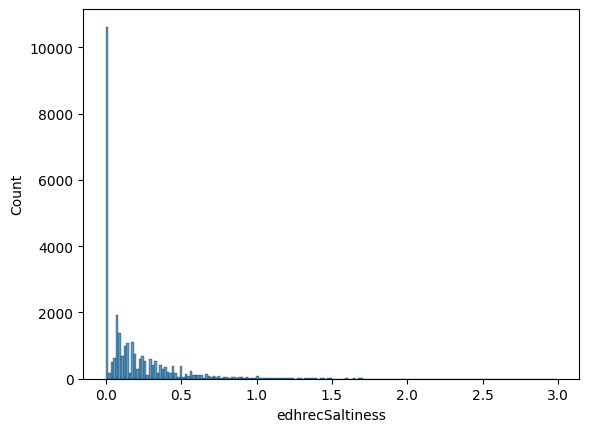

In [218]:
import seaborn as sns
sns.histplot(data.edhrecSaltiness)

### Lables Encoding

In [219]:
salt_dict = {
    'Fun': (0.0,0.1),
    'Notable': (0.1,0.5),
    'Annoying': (0.5,1.5),
    'Kill-On-Sight':(1.5,3.0),
}

def salt_to_sentiment(x):
    for i,key in enumerate(salt_dict):
        low,top = salt_dict[key]
        if(low<=x<=top): return key
    if(x<salt_dict.values()[0][0]): return list(salt_dict.keys)[0]
    else: return list(salt_dict.keys())[-1]

id2label = {id: label for id,label in enumerate(salt_dict)}
label2id = {label: id for id,label in enumerate(salt_dict.keys())}
num_labels = len(salt_dict.keys())
data['sentiment'] = data.edhrecSaltiness.apply(salt_to_sentiment)
data['sentiment_idx'] = data['sentiment'].apply(lambda x: label2id[x])

<Axes: xlabel='sentiment', ylabel='Count'>

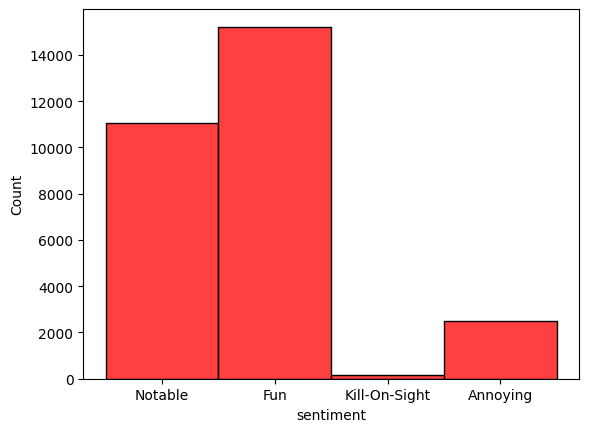

In [220]:
sns.histplot(data.sentiment, color='red')

## Set model checkpoint and other parameters

In [221]:
bert_checkpoint = 'bert-base-uncased'
# High batch size will hasten tranining but will use more GPU memory
batch_size = 64

## Model definition
The Transformers library already has access to TFPreTrained child classes that automatically adds the neccesary layers for some common tasks. TFBertModel is such a one. A model is build with two inputs vectors that form the input for the BERT model (a sequence of token ids and a sequence of masking vectors), a dropout layer and  Dense layer head connected to the BERT model pooled output (another linear layer with the [CLS] token representation vector as input).

In [222]:
import tensorflow
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [223]:
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_sequence_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_sequence_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
output = tensorflow.keras.layers.Dense(num_labels, activation='softmax')(x)

model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Note how sizes match: 113 for the input sequence length, output of size 768 (BERT embedding size and $d_model$ dimension of its transformer architecture) and the final Softmax of size 4.

In [224]:
model.compile(optimizer="Adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 113)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 113)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 113,                                         

## Preprocess and Tokenizer
BERT uses its own tokenizer since it is the one used to train its embeddings. BERT uses WordPiece as tokenizer and it is available in Transformers library.

In [225]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(bert_checkpoint)
# Test the thing
tokenizer.encode_plus(text=data.text[10])

{'input_ids': [101, 2043, 2023, 1035, 4003, 8039, 1996, 11686, 1010, 3443, 1037, 1014, 1013, 1015, 2317, 13555, 6492, 19204, 1012, 8688, 2178, 6492, 1024, 8040, 2854, 1015, 1012, 4019, 1517, 1063, 1017, 1065, 1063, 1038, 1065, 1063, 1038, 1065, 1010, 8340, 2176, 2060, 5329, 2013, 2115, 16685, 1012, 1006, 2017, 2089, 3459, 2023, 4003, 2013, 2115, 16685, 2005, 2049, 4019, 3465, 1012, 1007, 2023, 1035, 4003, 12976, 2007, 2048, 1009, 1015, 1013, 1009, 1015, 24094, 2006, 2009, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Loss was set as categorical cross entropy (same as pretrained model), so labels must me one-hot encoded.

In [226]:
from sklearn.preprocessing import label_binarize
y = label_binarize(data.sentiment, classes=list(salt_dict.keys()))
y

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

### Train/Test split
A test, validation and train split will be produced using de Scikitlearn stratified splitter so there's a sample from each class. This will obtain the splitted indexes.

In [227]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2 ,random_state = 42)
idx = splitter.split(
    # X is actually not needed, so a zerod array is used as placeholder.
    X = np.zeros(len(y)),
    y = data.sentiment
)
# Each iteration of enumerate(split(x,y)) is split_n,(train,test).
_,(idx_train,idx_val) = next(enumerate(idx)) 

Produce a function to obtain Tensorflow datasets from data indexes, with corresponding input dictionaries and labels and passing through a tokenizer.

In [263]:
from transformers import InputExample, InputFeatures
import numpy as np

def convert_data_to_examples(text, labels, idx_train, idx_val):
    # Armamos un "InputExample" para los datos de entrenamiento y validación
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i], 
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]
  
    return train_InputExamples, validation_InputExamples

 
def convert_examples_to_tf_dataset(examples, bert_tokenizer, num_labels, max_length=512):
    features = []

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )

    return tensorflow.data.Dataset.from_generator(
        gen,
        ({"input_ids": tensorflow.int32, "attention_mask": tensorflow.int32}, tensorflow.float32),
        (
            {
                "input_ids": tensorflow.TensorShape([None]),
                "attention_mask": tensorflow.TensorShape([None]),
            },
            tensorflow.TensorShape([num_labels]),
        ),
    )

In [229]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(data.text.values, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer, num_labels, max_length=max_sequence_length)
train_data = train_data.shuffle(100).batch(batch_size)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer, num_labels, max_length=max_sequence_length)
validation_data = validation_data.batch(batch_size)

## Tranining only the output classifier


In [261]:
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')

In [232]:
history2 = model.fit(train_data, epochs=10, validation_data=validation_data)

Epoch 1/10
362/362 [==============================] - 33s 92ms/step - loss: 0.9319 - accuracy: 0.5242 - val_loss: 0.9183 - val_accuracy: 0.5438
Epoch 2/10
362/362 [==============================] - 32s 89ms/step - loss: 0.9300 - accuracy: 0.5273 - val_loss: 0.9086 - val_accuracy: 0.5396
Epoch 3/10
362/362 [==============================] - 32s 89ms/step - loss: 0.9318 - accuracy: 0.5243 - val_loss: 0.9073 - val_accuracy: 0.5433
Epoch 4/10
362/362 [==============================] - 32s 89ms/step - loss: 0.9271 - accuracy: 0.5279 - val_loss: 0.9067 - val_accuracy: 0.5357
Epoch 5/10
362/362 [==============================] - 32s 89ms/step - loss: 0.9277 - accuracy: 0.5274 - val_loss: 0.9043 - val_accuracy: 0.5448
Epoch 6/10
362/362 [==============================] - 32s 89ms/step - loss: 0.9270 - accuracy: 0.5266 - val_loss: 0.9032 - val_accuracy: 0.5441
Epoch 7/10
362/362 [==============================] - 32s 88ms/step - loss: 0.9278 - accuracy: 0.5283 - val_loss: 0.9044 - val_accuracy:

## Training the whole model as intended
A shallow transfer learning only goes so far. These models were meant to be trained completely. Setup a new model with fully trainable parameters.

In [233]:
fully_trained_model = model

for layer in fully_trained_model.layers:
  layer.trainable = True

fully_trained_model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fully_trained_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 113)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 113)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 113,                                         

In [235]:
history = fully_trained_model.fit(train_data, epochs=10, validation_data=validation_data)

Epoch 1/10
362/362 [==============================] - 71s 195ms/step - loss: 0.6484 - accuracy: 0.7061 - val_loss: 0.9021 - val_accuracy: 0.6041
Epoch 2/10
362/362 [==============================] - 70s 194ms/step - loss: 0.6020 - accuracy: 0.7349 - val_loss: 0.9465 - val_accuracy: 0.5946
Epoch 3/10
362/362 [==============================] - 70s 195ms/step - loss: 0.5470 - accuracy: 0.7657 - val_loss: 1.0130 - val_accuracy: 0.5892
Epoch 4/10
362/362 [==============================] - 70s 194ms/step - loss: 0.5026 - accuracy: 0.7857 - val_loss: 1.0995 - val_accuracy: 0.5782
Epoch 5/10
362/362 [==============================] - 72s 200ms/step - loss: 0.4608 - accuracy: 0.8011 - val_loss: 1.1772 - val_accuracy: 0.5740
Epoch 6/10
362/362 [==============================] - 71s 197ms/step - loss: 0.4318 - accuracy: 0.8161 - val_loss: 1.2225 - val_accuracy: 0.5685
Epoch 7/10
362/362 [==============================] - 72s 199ms/step - loss: 0.4000 - accuracy: 0.8312 - val_loss: 1.2790 - val_ac

### Using AdamW optimizer
AdamW is just like Adam, but has a decoupled weigth decay.

(ref: https://arxiv.org/pdf/1711.05101)

In [240]:
from transformers import create_optimizer

num_epochs = 5
batches_per_epoch = len(idx_train) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

In [241]:
fully_trained_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fully_trained_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 113)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 113)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 113,                                         

In [242]:
history = fully_trained_model.fit(train_data, epochs=num_epochs, validation_data=validation_data)

Epoch 1/5
362/362 [==============================] - 84s 205ms/step - loss: 0.3236 - accuracy: 0.8663 - val_loss: 1.6222 - val_accuracy: 0.5467
Epoch 2/5
362/362 [==============================] - 71s 196ms/step - loss: 0.2924 - accuracy: 0.8794 - val_loss: 1.7372 - val_accuracy: 0.5319
Epoch 3/5
362/362 [==============================] - 71s 196ms/step - loss: 0.2552 - accuracy: 0.8956 - val_loss: 1.7758 - val_accuracy: 0.5479
Epoch 4/5
362/362 [==============================] - 70s 194ms/step - loss: 0.2362 - accuracy: 0.9042 - val_loss: 1.6991 - val_accuracy: 0.5706
Epoch 5/5
362/362 [==============================] - 70s 195ms/step - loss: 0.2099 - accuracy: 0.9157 - val_loss: 1.7791 - val_accuracy: 0.5680


## Save model

In [258]:
fully_trained_model.save_weights('./mtgjson_dataset/bert_mtg_weights.h5')

## Analysis
A typical deep learning overfitting is observed in the evolution of trainig accuracy vs. validation accuracy. The traning went for too long and the network has the complexity to learn "from memory" which texts are what. Given that the models is using an optimizer with regularization and a dropout layers, the overfitting in this case is probably due to:
- Too many parameters being trained for too long.
- Highly imbalanced classes. This is probably the main culprit, as most classes are 0 and the network is being biased towards it and learning by heart the rest in the training data set.
- Too specific vocabulary in the MTG dataset, most filtered out.
- State based and other removed features affecting the actual sentiment.

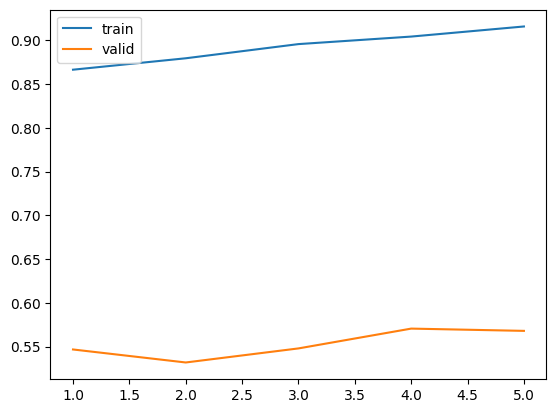

In [262]:
plot_train_metrics(history)

In [300]:
# From https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.3f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [284]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_hat_prob = fully_trained_model.predict(validation_data)

91/91 [==============================] - 7s 72ms/step


In [296]:
y_hat_prob.argmax(axis=1)

array([2, 0, 1, ..., 1, 1, 0], dtype=int64)

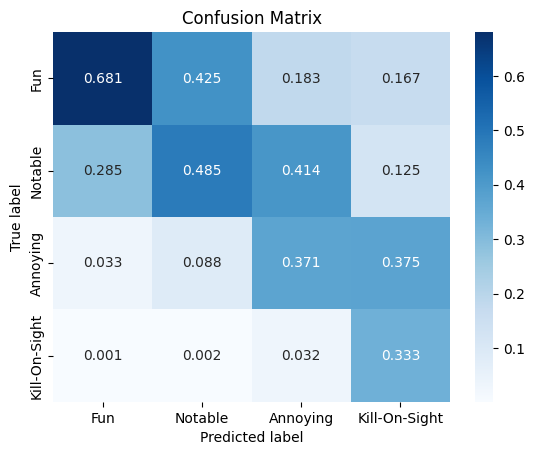

In [303]:
cf = confusion_matrix(y_true=y[idx_val].argmax(axis=1), y_pred=y_hat_prob.argmax(axis=1), normalize='pred')
make_confusion_matrix(cf, title='Confusion Matrix',percent=False,sum_stats=False,categories=salt_dict.keys(),count=True)

In [277]:
def get_sentiment(text):
    tf_batch = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_sequence_length, # truncates if len(s) > max_length
        return_token_type_ids=False,
        return_attention_mask=True,
        padding = 'max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
        truncation=True,
        return_tensors='tf'
    )

    X_ = [tf_batch['input_ids'],  
              tf_batch['attention_mask']]

    y_prob = fully_trained_model.predict(X_)
    y_prob = np.argmax(y_prob, axis=1)
    print("Class:", id2label[y_prob[0]])

In [278]:
# Well, that depends on who's winning.
get_sentiment("You win the game") # Kill on sight

1/1 [==============================] - 0s 32ms/step
Class: Fun


In [310]:
get_sentiment("Everyone sacrifices all permanents") # Annoying.

1/1 [==============================] - 0s 36ms/step
Class: Annoying


In [309]:
get_sentiment("Permaments player control do not untap during the untap phase") # Very annoying

1/1 [==============================] - 0s 33ms/step
Class: Annoying


In [311]:
get_sentiment("{0} tap target permanent an opponent controls") # Kill on sight

1/1 [==============================] - 0s 33ms/step
Class: Notable


## Conclussion
The model turned out to be extremely biased towads the '0' class due to class imbalance and overfitting. As further work on this dataset, class data must be rectified by pruning or eliminating the '0' class data. Also the BERT model would benefit from a whole new pre-training using the MTG vocabulary. That would mean creating the MLM and NSP datasets and objetive tasks and replacing the input embedding. 